# GMT PSF & image simulator

In [1]:
# Load python librairies
import os
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
cmap = plt.cm.viridis
cmap.set_bad(color=cmap(0))

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
# Ignore some unrelated deprecation warnings from current version of Matplotlib
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

Populating the interactive namespace from numpy and matplotlib


<ipython-input-1-d1b11b82deb0>:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cmap.set_bad(color=cmap(0))


In [2]:
import poppy
from astropy import units as u
from astropy.io import fits
from astropy import constants as const
from scipy.signal import fftconvolve

<AxesSubplot:title={'center':'Transmittance for unnamed'}, ylabel='[meters]'>

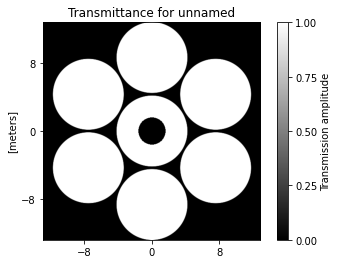

In [3]:
# -----Build GMT aperture-----
primary = poppy.optics.MultiCircularAperture(rings=1, segment_radius=8.365*u.m/2, gap=0.293*u.m)
secondary = poppy.SecondaryObscuration(secondary_radius=3.2*u.m/2)
gmt_aperture = poppy.CompoundAnalyticOptic(opticslist = [primary, secondary])
gmt_aperture.display(what="intensity", colorbar_orientation="vertical")

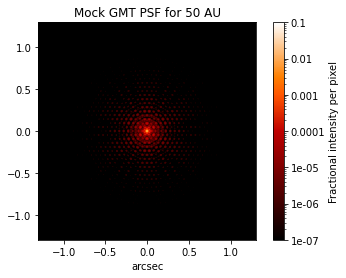

In [4]:
# -----Calculate GMT PSF-----
osys = poppy.OpticalSystem()
osys.add_pupil(gmt_aperture)
osys.add_detector(pixelscale=0.005, fov_arcsec=2.6)  # in arcsec
gmt_psf = osys.calc_psf(2e-6)   # wavelength in meters
osys.calc_psf()

#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
poppy.display_psf(gmt_psf, scale='log', title="Mock GMT PSF for 50 AU")
#poppy.display_psf(gmt_psf2, scale='log', ax=ax2, title="Mock GMT PSF for 50 AU")

pixel scale 1 is 0.00480775658251284 arcsec/pix
image unit is Jy / pixel


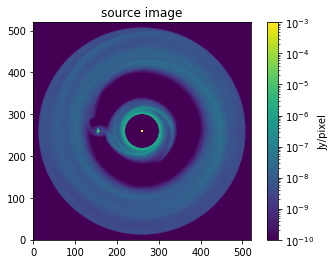

In [18]:
# -----Import fits image-----
with fits.open("../../RADMC3D/10jup50au/npix520lam214inc0.fits") as hdulist:
    hdr = hdulist[0].header
    img = hdulist[0].data[0]

plt.imshow(img, cmap=cmap, norm=LogNorm(vmin=1e-10, vmax=1e-3))
plt.title("source image")
plt.colorbar().set_label('Jy/pixel')

print("pixel scale 1 is", hdr['CDELT1'] * -3600, "arcsec/pix")
print('image unit is', hdr['BUNIT'])

In [22]:
def sim_gmt(img, lam_ref, t_exp, coron, gfilter, psf=None, noise='sum', detnoise=True):
    # telescope parameters
    D = 25.4 * u.m
    QE = 0.9
    gain = 2

    # filters
    if lam_ref == 1.25:
        filter = 'hJ'
        dlam = (1.35 - 1.10) * u.um
    elif lam_ref == 1.64:
        filter = 'hH'
        dlam = (1.80 - 1.47) * u.um
    elif lam_ref == 2.14:
        filter = 'hK'
        dlam = (2.51-2.04) * u.um

    # calc conv factor from Jy to photon count
    lam_ref = lam_ref * u.um
    E_ph = const.h * const.c / lam_ref.to(u.m)
    Jy2SI = (1 * u.Jy).to(u.J * u.s**-1 * u.m**-2 * u.um**-1, equivalencies=u.spectral_density(2* u.um))
    Jy2DN = (Jy2SI / E_ph) * (D/2)**2 * dlam * QE * (1 / gain)
    print("1 Jy at {0:5.2f} corresponds to {1:5.2f}".format(lam_ref, Jy2DN))

    # convert img to DN/s
    imgDN = img * Jy2DN.value * t_exp

    # coronagraph - dim the star by 99%
    if coron:
        coron_mask = np.ones((520,520))
        cen = int(520/2)
        rmask = 1
        coron_mask[cen-rmask:cen+rmask, cen-rmask:cen+rmask] = 0.01

        imgDN = np.multiply(imgDN, coron_mask)


    # -----Convolve image with PSF-----
    if psf is not None:
        conv_img = fftconvolve(imgDN, psf, mode='same')
    else:
        conv_img = imgDN


    # -----Guassian filter-----
    from scipy.ndimage import gaussian_filter
    conv_img = gaussian_filter(conv_img, sigma=int(gfilter))
    # plt.imshow(conv_img, cmap=cmap, norm=LogNorm(), origin='lower')
    # plt.title("convolved image")
    # plt.colorbar().set_label('DN')

    # -----Add Possion noise-----
    if noise == 'sum':
        noise_phot = np.random.poisson(lam=np.ones((520,520)) * conv_img.sum())
    elif noise == 'ori':
        noise_phot = np.random.poisson(lam=conv_img)

    # -----Add detector noise-----
    if detnoise:
        noise_det = np.random.poisson(lam=np.ones((520,520)) * conv_img.max()/5)
    else:
        noise_det = np.ones((520,520))*1e-10

    noise = noise_det+noise_phot
    det_img = noise + conv_img
    
    return det_img, noise_phot, noise_det

1 Jy at  2.14 um corresponds to 275432742.36 1 / s


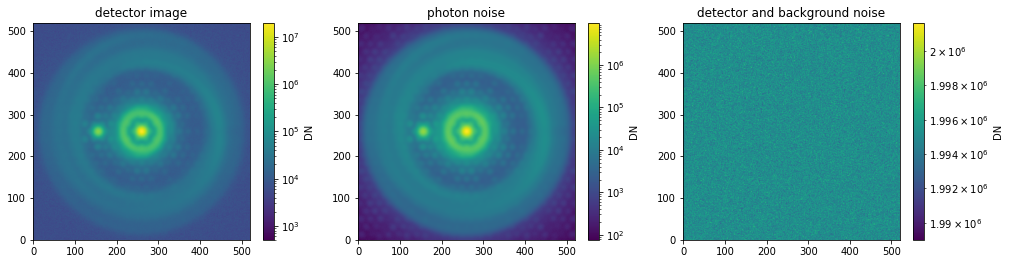

In [37]:
#imgdet = sim_gmt(img, lam_ref=2.14, t_exp=500, coron=True, gfilter=0, psf=gmt_psf[0].data, noise='ori', detnoise=True)
imgdet = sim_gmt(img, lam_ref=2.14, t_exp=3600, coron=True, gfilter=5, psf=gmt_psf[0].data, noise='ori', detnoise=True)

plt.figure(figsize=(16.5,4))
plt.subplot(1,3,1)
size=imgdet[0].shape[0]
bgrate = imgdet[0].min()
imgsub = imgdet[0] - bgrate*np.ones((size,size))
plt.imshow(imgsub, cmap=cmap, norm=LogNorm(vmin=5e2), origin='lower')
plt.title("detector image")
plt.colorbar().set_label('DN')

plt.subplot(1,3,2)
plt.imshow(imgdet[1], cmap=cmap, norm=LogNorm(), origin='lower')
plt.title("photon noise")
plt.colorbar().set_label('DN')

plt.subplot(1,3,3)
plt.imshow(imgdet[2], cmap=cmap, norm=LogNorm(), origin='lower')
plt.title("detector and background noise")
plt.colorbar().set_label('DN')